## S-Mobile: Predicting Customer Churn
* Team-lead GitLab userid: gul001
* Group name: 15
* Team member names: Chia-Hsien Ho, Qing Gong, Guozheng Li

## Setup

Please complete this Jupyter notebook by answering the questions in `s-mobile.pdf` on Canvas (week9/). Create a Notebook and HTML file with all your results and comments and push both the Notebook and HTML file to GitLab when your team is done. All results MUST be reproducible (i.e., the TA and I must be able to recreate the HTML from the Jupyter Notebook file without changes or errors). This means that you should NOT use any python-packages that are not part of the rsm-msba-spark docker container.

This is the fourth group assignment for MGTA 455 and you will be using git and GitLab. If two people edit the same file at the same time you could get what is called a "merge conflict". git will not decide for you who's change to accept so the team-lead will have to determine which edits to use. To avoid merge conflicts, **always** "pull" changes to the repo before you start working on any files. Then, when you are done, save and commit your changes, and then push them to GitLab. Make "pull first" a habit!

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance, plot_partial_dependence
from sklearn.model_selection import (
    GridSearchCV,
    ShuffleSplit,
    StratifiedShuffleSplit,
    train_test_split,
)
import xgboost as xgb

# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150

In [4]:
## load the data - this dataset must NOT be changed
s_mobile = pd.read_pickle("data/s_mobile.pkl")
s_mobile["churn_yes"] = (s_mobile["churn"] == "yes").astype(int)

If you want access to the full 5M row dataset, use the dropbox link below.

https://www.dropbox.com/s/eli6a1q6qisacci/s_mobile_1M.pkl?dl=1

The downside to using the dataset with 1M rows is, of course, that estimation time will increase substantially. I do NOT recommend you use this dataset to select your final model or for tuning hyper parameters. You can, however, use this larger dataset to re-estimate your chosen model and generate profit estimates for the representative sample.

In [5]:
# show dataset description
rsm.describe(s_mobile)

## S-mobile

Dataset used to investigate opportunities to decrease customer churn at S-mobile. The sample consists of three parts:

1. A training sample with 27,300 observations and a 50% churn rate ("training == 1")
2. A test sample with 11,700 observations and a 50% churn rate ("training == 0")
3. A representative sample with 30,000 observations and a churn rate of 2%, i.e., the actual monthly churn rate for S-mobile ("is.na(training)" or "representative == 1")

## Variables

* customer: Customer ID
* churn: Did consumer churn in the last 30 days? (yes or no)
* changer: % change in revenue over the most recent 4 month period
* changem: % change in minutes of use over the most recent 4 month period
* revenue: Mean monthly revenue in SGD
* mou: Mean monthly minutes of use
* overage: Mean monthly overage minutes
* roam: Mean number of roaming calls
* conference: Mean number of conference calls
* months: # of months the customer has had service with S-Mobile
* uniqsubs: Number of individuals listed on the customer account
* custcare: Mean number of calls to customer care 
* retcalls: Number of calls by the customer to the retention team
* dropvce: Mean number of dropped voice calls 
* eqpdays: Number of days customer has owned current handset
* refurb: Handset is refurbished (no or yes)
* smartphone: Handset is a smartphone (no or yes)
* creditr: High credit rating as opposed to medium or low (no or yes)
* mcycle: Subscriber owns a motorcycle (no or yes)
* car: Subscriber owns a car (no or yes)
* travel: Subscriber has traveled internationally (no or yes)
* region: Regions delineated by the 5 Community Development Council Districts (e.g., CS is Central Singapore)
* occupation: Categorical variable with 4 occupation levels (professional, student, retired, or other)
* training: 1 for training sample, 0 for test sample, NA for representative sample
* representative: 1 for representative sample, 0 for training and test sample


Use `smf.glm` with `freq_weights` and `cov_type` like in the below example
    
```python
lr = smf.glm(
    formula="churn_yes ~ changer + changem + ...",
    family=Binomial(link=logit()),
    data=pentathlon_nptb.query("training == 1"),
    freq_weights=s_mobile.loc[mobile.training == 1, "cweight"],
).fit(cov_type="HC1")
```

In [6]:
# run python code from another notebook
%run ./sub-notebooks/model1.ipynb

     index     OR   OR%  2.5%  97.5% p.values    
1  changer  1.001  0.1%   1.0  1.002    0.006  **


In [7]:
# importing functions from a module/package
from utils import functions
functions.example()


You just accessed a function from your first python packages!
Change the code in utils/function.py to whatever you need for this assignment
Use 'from utils import functions' to get access to your code
You can add modules to import from by adding additional .py files to the 'utils' directory
Note: If you make changes to the content of this file you will have to restart the notebook kernel to get the updates



## Exploratory Analysis

In [8]:
s_mobile.head()

,customer,churn,changer,changem,revenue,mou,overage,roam,conference,months,...,smartphone,highcreditr,mcycle,car,travel,region,occupation,training,representative,churn_yes
0,U86940794,yes,109,81,62,600,141,0,0,8,...,yes,no,no,no,no,CS,other,0.0,0,1
1,U56788559,no,0,3,54,146,0,0,0,8,...,yes,yes,no,no,no,SE,other,0.0,0,0
2,U47928407,no,0,-9,39,1158,96,0,1,9,...,yes,no,yes,no,yes,NW,professional,NaN,1,0
3,U75794640,no,0,-8,35,560,0,0,0,37,...,yes,yes,yes,no,no,NW,retired,1.0,0,0
4,U41010771,no,-2,-8,100,1888,112,9,0,20,...,yes,no,yes,yes,no,SW,other,NaN,1,0


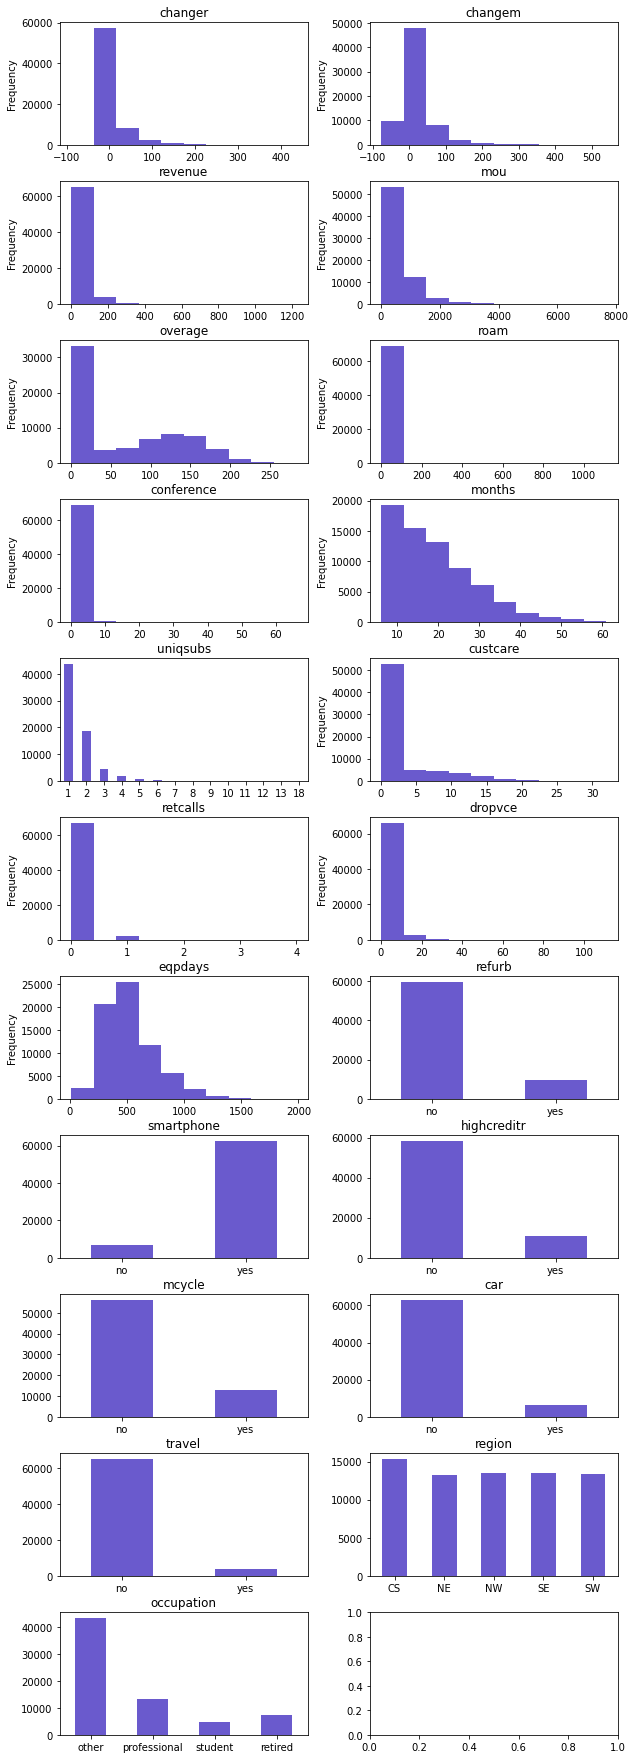

In [9]:
rsm.distr_plot(s_mobile.loc[:, "changer":"occupation"])

In [10]:
s_mobile[["changer", "changem", "revenue", "mou", "overage", "roam", "conference", "months", 
          "uniqsubs", "custcare", "retcalls", "dropvce", "eqpdays"]].corr(method ='pearson')

,changer,changem,revenue,mou,overage,roam,conference,months,uniqsubs,custcare,retcalls,dropvce,eqpdays
changer,1.000000,0.410062,0.107942,0.068935,0.218592,0.023826,0.018732,-0.037496,0.002851,0.023780,0.005444,0.027436,-0.060257
changem,0.410062,1.000000,-0.015116,-0.064465,0.006937,-0.006031,-0.018796,-0.007174,0.003714,-0.048600,-0.007980,-0.068100,-0.011464
revenue,0.107942,-0.015116,1.000000,0.704275,0.562382,0.290932,0.201157,-0.000712,-0.017986,0.242573,0.016938,0.435220,-0.216022
mou,0.068935,-0.064465,0.704275,1.000000,0.529901,0.110639,0.293922,-0.067256,-0.036169,0.470431,0.014219,0.598463,-0.308067
overage,0.218592,0.006937,0.562382,0.529901,1.000000,0.051951,0.148996,-0.026864,-0.016769,0.244749,0.019652,0.333862,-0.156627
roam,0.023826,-0.006031,0.290932,0.110639,0.051951,1.000000,0.019597,-0.008589,-0.004887,0.028338,-0.002036,0.068705,-0.028202
conference,0.018732,-0.018796,0.201157,0.293922,0.148996,0.019597,1.000000,-0.053195,-0.022126,0.225100,0.011791,0.270589,-0.105664
months,-0.037496,-0.007174,-0.000712,-0.067256,-0.026864,-0.008589,-0.053195,1.000000,0.021264,-0.140059,0.068240,-0.043132,0.449924
uniqsubs,0.002851,0.003714,-0.017986,-0.036169,-0.016769,-0.004887,-0.022126,0.021264,1.000000,-0.096530,-0.009576,-0.025948,-0.023111
custcare,0.023780,-0.048600,0.242573,0.470431,0.244749,0.028338,0.225100,-0.140059,-0.096530,1.000000,0.034505,0.358695,-0.231690


Show descriptive statistics in the training data

In [11]:
pd.get_dummies(
    s_mobile.loc[s_mobile.training == 1, "churn":],
).agg(["mean", "std", "min", "max"]).T

,mean,std,min,max
changer,8.661245,28.956823,-62.0,305.0
changem,15.211392,51.885577,-78.0,521.0
revenue,57.211136,43.258950,0.0,856.0
mou,515.322308,525.458925,0.0,7668.0
overage,66.274286,69.258068,0.0,283.0
roam,1.197253,7.254327,0.0,692.0
conference,0.263480,1.083898,0.0,56.0
months,18.781502,9.595614,6.0,61.0
uniqsubs,1.546227,0.891051,1.0,18.0
custcare,2.288132,4.192970,0.0,32.0


Show churn in the representative sample

In [12]:
pd.get_dummies(
    s_mobile.loc[s_mobile.representative == 1, "churn":],
).agg(["mean", "std", "min", "max"]).T

,mean,std,min,max
changer,8.310567,28.496320,-90.0,437.0
changem,17.254533,51.375390,-78.0,540.0
revenue,56.634800,43.339533,0.0,1223.0
mou,540.767067,536.368824,0.0,7359.0
overage,61.723400,67.846131,0.0,265.0
roam,1.187867,10.058579,0.0,1112.0
conference,0.296400,1.284316,0.0,66.0
months,18.592767,9.928488,6.0,61.0
uniqsubs,1.501367,0.840013,1.0,12.0
custcare,2.514533,4.357846,0.0,32.0


The average churn probability from the representative sample

In [13]:
sum(s_mobile.query("representative == 1").churn_yes == 1) / len(s_mobile.query("representative == 1"))

0.02

## Pre-processing

In [14]:
# standardization

is_num = ["changer", "changem", "revenue", "mou", "overage", "roam", "conference", "months", 
          "uniqsubs", "custcare", "retcalls", "dropvce", "eqpdays"]

scaler = preprocessing.StandardScaler()
sf = scaler.fit(s_mobile[is_num])
sf.scale_ = sf.scale_ * 2
s_mobile[is_num] = sf.transform(s_mobile[is_num])

## Case Analysis

### 1. Develop a model to predict customer churn

Generate (case) weights to scale the predicted churn probabilities

In [15]:
s_mobile["cweight"] = rsm.ifelse(s_mobile.churn == "yes", 1, 49)

Estimating a Logistic Regression with weights (standardized).  
Dropped `car`, `custcare`, `conference` variables due to high p-value

In [16]:
lr = smf.glm(
    formula="churn_yes ~ changer + changem + revenue + mou + overage + roam + months + uniqsubs + \
             retcalls + dropvce + eqpdays + refurb + smartphone + highcreditr + mcycle + travel + region + occupation",
    family=Binomial(link=logit()),
    data=s_mobile.query("training == 1"),
    freq_weights=s_mobile.loc[s_mobile.training == 1, "cweight"]
)
lr_model = lr.fit(cov_type="HC1")
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              churn_yes   No. Observations:                27300
Model:                            GLM   Df Residuals:                   682476
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -63798.
Date:                Mon, 01 Mar 2021   Deviance:                   1.2760e+05
Time:                        20:14:08   Pearson chi2:                 6.91e+05
No. Iterations:                     9                                         
Covariance Type:                  HC1                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -3.4192      0.034   -101.812      0.000      -3.485      -3.353
refurb[T.yes]                  0.2757      0.025     11.012      0.000       0.227       0.325
smartphone[T.yes]             -0.0910      0.030     -2.989      0.003      -0.151      -0.031
highcreditr[T.yes]            -0.7325      0.030    -24.067      0.000      -0.792      -0.673
mcycle[T.yes]                 -0.1284      0.023     -5.611      0.000      -0.173      -0.084
travel[T.yes]                 -0.2479      0.040     -6.250      0.000      -0.326      -0.170
region[T.NE]                  -0.4392      0.027    -16.562      0.000      -0.491      -0.387
region[T.NW]                  -0.4145      0.026    -15.800      0.000      -0.466      -0.363
region[T.SE]                  -0.4293      0.026    -16.352      0.000      -0.481      -0.378
region[T.SW]                  -0.4662      0.026    -17.602      0.000      -0.518      -0.414
occupation[T.professional]     0.3487      0.022     15.579      0.000       0.305       0.393
occupation[T.student]          0.6418      0.031     20.790      0.000       0.581       0.702
occupation[T.retired]         -1.6885      0.054    -31.236      0.000      -1.794      -1.583
changer                        0.0655      0.019      3.456      0.001       0.028       0.103
changem                       -0.1498      0.024     -6.286      0.000      -0.196      -0.103
revenue                       -0.0397      0.030     -1.328      0.184      -0.098       0.019
mou                           -0.3946      0.035    -11.171      0.000      -0.464      -0.325
overage                        0.5859      0.024     24.735      0.000       0.539       0.632
roam                           0.1434      0.018      7.929      0.000       0.108       0.179
months                        -0.3427      0.022    -15.561      0.000      -0.386      -0.300
uniqsubs                       0.0655      0.017      3.912      0.000       0.033       0.098
retcalls                       0.2371      0.013     18.338      0.000       0.212       0.262
dropvce                        0.1196      0.022      5.482      0.000       0.077       0.162
eqpdays                        0.6238      0.023     27.348      0.000       0.579       0.669
==============================================================================================
"""

In [17]:
rsm.vif(lr)

,variable,vif,Rsq
0,mou,2.800,0.643
1,revenue,2.485,0.598
2,eqpdays,1.673,0.402
3,overage,1.648,0.393
4,dropvce,1.620,0.383
5,region[T.NW],1.458,0.314
6,region[T.SE],1.457,0.314
7,region[T.SW],1.455,0.313
8,region[T.NE],1.453,0.312
9,months,1.364,0.267


In [18]:
rsm.or_ci(lr_model, importance=True, data=s_mobile[s_mobile.training == 1]).sort_values("importance", ascending=False).reset_index(drop=True)

,index,OR,OR%,2.5%,97.5%,p.values,,dummy,importance,wmean,wstd,min,max
0,occupation[T.retired],0.185,-81.5%,0.166,0.205,< .001,***,True,5.411,0.137,0.344,0.000,1.000
1,highcreditr[T.yes],0.481,-51.9%,0.453,0.510,< .001,***,True,2.080,0.180,0.384,0.000,1.000
2,occupation[T.student],1.900,90.0%,1.788,2.018,< .001,***,True,1.900,0.055,0.227,0.000,1.000
3,eqpdays,1.866,86.6%,1.785,1.951,< .001,***,False,1.866,-0.035,0.484,-1.096,3.165
4,overage,1.797,79.7%,1.715,1.882,< .001,***,False,1.797,-0.018,0.495,-0.467,1.594
5,region[T.SW],0.627,-37.3%,0.596,0.661,< .001,***,True,1.594,0.202,0.401,0.000,1.000
6,region[T.NE],0.645,-35.5%,0.612,0.679,< .001,***,True,1.552,0.199,0.399,0.000,1.000
7,region[T.SE],0.651,-34.9%,0.618,0.685,< .001,***,True,1.536,0.199,0.399,0.000,1.000
8,region[T.NW],0.661,-33.9%,0.628,0.696,< .001,***,True,1.514,0.199,0.399,0.000,1.000
9,mou,0.674,-32.6%,0.629,0.722,< .001,***,False,1.484,0.017,0.515,-0.496,6.738


In [19]:
# regresssion model rsquared
rsm.model_fit(lr_model)


Pseudo R-squared (McFadden): 0.047
Pseudo R-squared (McFadden adjusted): 0.046
Log-likelihood: -63797.64, AIC: 127643.28, BIC: 127917.684
Chi-squared: 691221.653 df(23), p.value < 0.001 
Nr obs: 27,300



RMSE and AUC performance of the regression model on the training set.

In [20]:
# prediction
ypred_lr = lr_model.predict(s_mobile)
s_mobile = s_mobile.assign(pred_lr = lr_model.predict(s_mobile))

# regression model rmse
rmse_lr = rmse(s_mobile.query("training == 0").churn_yes, lr_model.predict(s_mobile.query("training == 0")))

# regression model auc
auc_lr = roc_auc_score(s_mobile.query("training == 0").churn_yes, lr_model.predict(s_mobile.query("training == 0")))

# regression model performance
model_performance = pd.DataFrame({
    'Model': ['logistic'],
    'RMSE': [round(rmse_lr,4)],
    'AUC': [round(auc_lr,4)]
})
model_performance

,Model,RMSE,AUC
0,logistic,0.6863,0.6945


The cumulative gains plot and lift plot below show the model prediction from both training and test set.
It doesn't show a sign of overfitting.

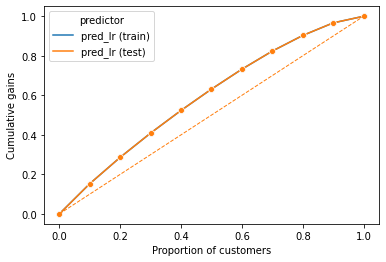

In [21]:
# check if model has overfitting issue
dct = {"train": s_mobile.query("training == 1"), "test": s_mobile.query("training == 1")}
fig = rsm.gains_plot(dct, "churn_yes", 1, "pred_lr")

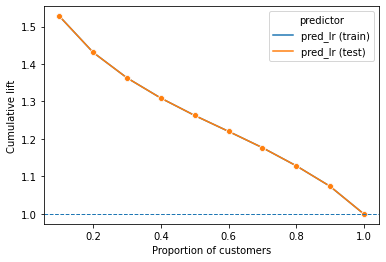

In [22]:
fig = rsm.lift_plot(dct, "churn_yes", 1, "pred_lr")

### 2. Use the model output from a logistic regression to understand the main drivers of churn and report on the key factors that predict customer churn and their relative importance

Check the odds ratio plot

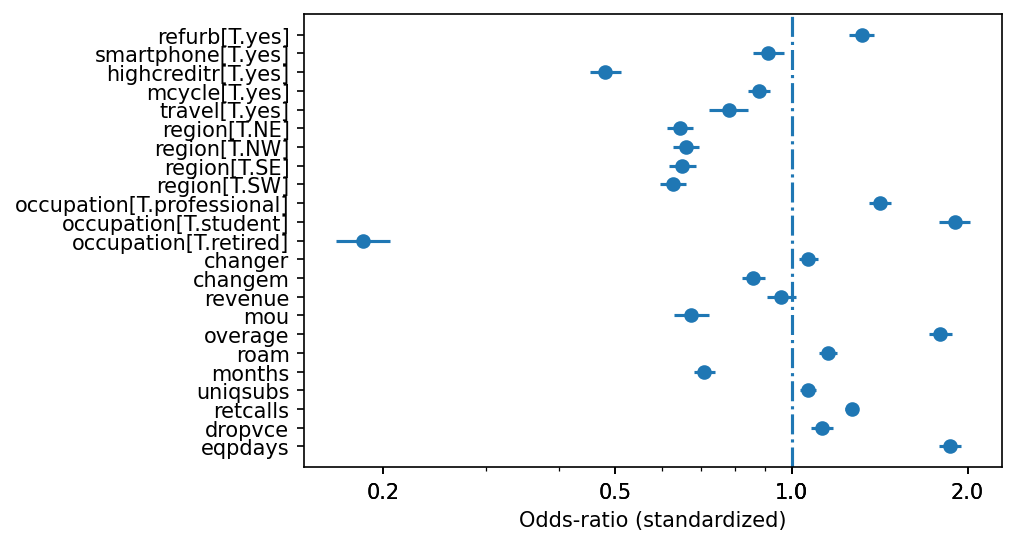

In [23]:
mpl.rcParams["figure.dpi"] = 150
fig = rsm.or_plot(lr_model)
fig = fig.set_xlabel("Odds-ratio (standardized)")

Alternative model to check variable importance

In [24]:
def importance(clf, X, y, cn):
    imp = permutation_importance(
        clf, X, y, scoring="roc_auc", n_repeats=10, random_state=1234
    )
    data = pd.DataFrame(imp.importances.T)
    data.columns = cn
    order = data.agg("mean").sort_values(ascending=False).index
    fig = sns.barplot(
        x="value", y="variable", color="slateblue", data=pd.melt(data[order])
    )
    fig.set(title="Permutation Importances", xlabel=None, ylabel=None)
    return fig

In [25]:
X = pd.get_dummies(s_mobile.loc[:, "changer":"occupation"], drop_first=True)
y = s_mobile.churn_yes

In [26]:
clf = xgb.XGBClassifier(
    max_depth=2,
    n_estimators=100,
    objective="binary:logistic",
    use_label_encoder=False,
    scale_pos_weight=1 / 49,
    eval_metric="auc",
    random_state=1234,
).fit(X[s_mobile.training == 1], y[s_mobile.training == 1], verbose=True)

Check that the predicted probabilities in the representative dataset are scaled appropriately

In [27]:
clf.predict_proba(X[s_mobile.representative == 1])[:, 1].mean().round(3)

0.02

Check the permutation_importance from sklearn

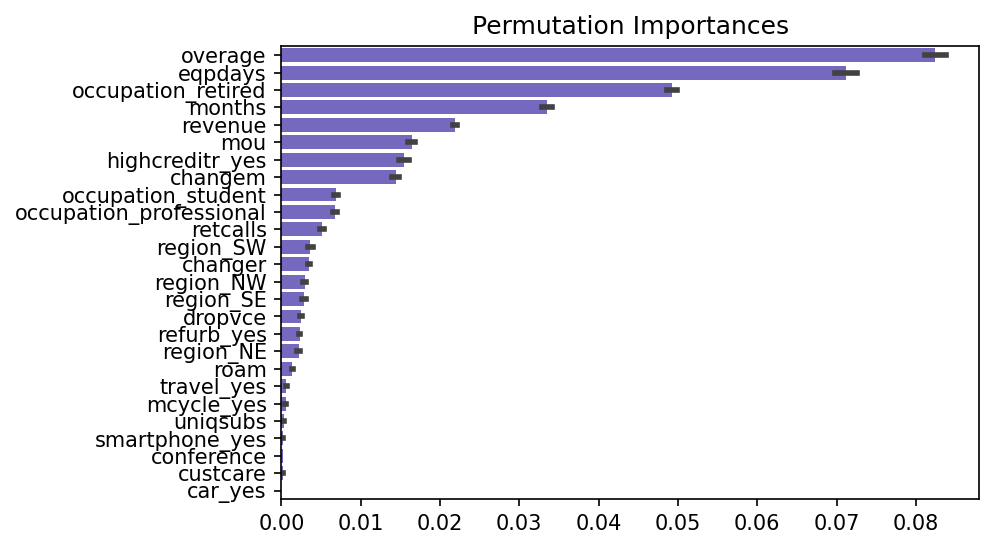

In [28]:
fig = importance(clf, X[s_mobile.training == 1], y[s_mobile.training == 1], X.columns)

#### Key Factor 1: "overage"

The permutation importance from the training set shows that `overgage` is the most important variable and the odds ratio is 1.797, which also indicates a large and positive impact on churn rate. 

#### Key Factor 2: "eqpdays"

Both the permutation importance and the odds ratio show that `eqpdays` has significant effect on churn rate.
When the customers own their current handset for a long time, they are more likely to churn out.
One possible explanation is that when they buy new handset, they might also want to switch to a new carrier.

#### Key Factor 3: "occupation"

Both the permutation importance and the odds ratio show that `occupation` has significant effect on churn rate.  
There are four levels of `occupation`: other, student, professional and retired.
Comparing to other, being a student or professional leads to higher probability of churn out.
Being retired leads to lower probability of churn out.

### 3. Use insights on churn drivers to develop actions/offers/incentives

#### Action 1: Control the mean monthly overage minutes of each customer

- Offer: downgrade plan to a plan with less monthly minutes and cheaper price

- Incentives: The customers churn out because they feel they are wasting money when they are not utilizing the plan to the fullest.

#### Action2: Offer promotion to customers with high `eqpdays` and tendency to buy new handsets 

- Offer: When customers decided to buy new handsets, offer plan with promotion

- Incentives: when they buy new handset, they might also want to switch to a new carrier.

#### Action3: Optimal pricing for customers of different `occupation`

- Offer: student plan with lower price and less monthly minutes

- Incentives: students are more sensitive to prices

### 4. Quantify the impact of these actions/offers/incentives on the probability of churn

#### Action1: Control the mean monthly overage minutes of each customer

We can start by calculating churn numbers and probability for those customers that experienced excessive monthly overage minutes in the representative sample.  
We use the logistic regression model estimated above to generate predictions as if we controlled all monthly overage minutes by setting the values in the `overage` column to 0.

In the table below we can see that the actual churn rate was 2.12%.  
Our logistic regression model predicts that controlling monthly overage minutes for these customers would reduce churn rate to 1.77% on average.

In [36]:
# impact of eliminating shipping delays on churn probability
s_mobile_rep = s_mobile.query("representative == 1").copy()
s_mobile_rep["p_delay0"] = lr_model.predict(s_mobile[s_mobile.representative == 1].assign(overage=0))
s_mobile_rep.loc[s_mobile_rep.overage > 0, ["churn_yes", "p_delay0"]].agg(["count", "mean"]).round(4)

,churn_yes,p_delay0
count,13424.0000,13424.0000
mean,0.0212,0.0177


#### Action2: 

In [38]:
s_mobile_rep.eqpdays.mean()

-0.03673017946526835

### 5. Decide which actions/offers/incentives to target to which customers

### 6. Evaluate the economics: For each action/offer/incentive evaluate the profitability implications using a 5-year (60 month) time window